# K-Nearest Neighbors on Big Mart Sales Data Set from Analytics Vidhya

The notebook is compiled from the tutorial https://www.analyticsvidhya.com/blog/2018/08/k-nearest-neighbor-introduction-regression-python/

The Big Mart Sales III challenge that is refered to in the tutorial is here https://datahack.analyticsvidhya.com/contest/practice-problem-big-mart-sales-iii/

## Problem Statement
The data scientists at BigMart have collected 2013 sales data for 1559 products across 10 stores in different cities. Also, certain attributes of each product and store have been defined. The aim is to build a predictive model and find out the sales of each product at a particular store.

Using this model, BigMart will try to understand the properties of products and stores which play a key role in increasing sales. 

Please note that the data may have missing values as some stores might not report all the data due to technical glitches. Hence, it will be required to treat them accordingly.

## Data
We have train (8523) and test (5681) data set, train data set has both input and output variable(s). You need to predict the sales for test data set.

| Variable                                                                            |        Description  |
|:------------------------------------------------------------------------------------|:--------------------|
|Item_Identifier|Unique product ID|
|Item_Weight|Weight of product|
|Item_Fat_Content|Whether the product is low fat or not|
|Item_Visibility|The % of total display area of all products in a store allocated to the particular product|
|Item_Type|The category to which the product belongs|
|Item_MRP|Maximum Retail Price (list price) of the product|
|Outlet_Identifier|Unique store ID|
|Outlet_Establishment_Year|The year in which store was established|
|Outlet_Size|The size of the store in terms of ground area covered|
|Outlet_Location_Type|The type of city in which the store is located|
|Outlet_Type|Whether the outlet is just a grocery store or some sort of supermarket|
|Item_Outlet_Sales|Sales of the product in the particulat store. This is the outcome variable to be predicted.|

 

## Evaluation Metric:

Your model performance will be evaluated on the basis of your prediction of the sales for the test data (test.csv), which contains similar data-points as train except for the sales to be predicted. Your submission needs to be in the format as shown in "SampleSubmission.csv".

We at our end, have the actual sales for the test dataset, against which your predictions will be evaluated. We will use the Root Mean Square Error value to judge your response.

$$RMSE = \sqrt{\frac{\sum_{i=1}^n (Predicted_i - Actual_i)^2}{N}}$$
where:
+ $N$ total number of observations 
+ $Predicted$ the response entered by user
+ $Actual$ actual values of sales

Also, note that the test data is further divided into Public (25%) and Private (75%) data. Your initial responses will be checked and scored on the Public data. But, the final rankings will be based on score on Private data set. Since this is a practice problem, we will keep declare winners after specific time intervals and refresh the competition.

In [1]:
import os
import pandas as pd
import numpy as np

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Visualization
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_colwidth', 50)

sns.set(context='notebook', style='whitegrid', rc={'figure.figsize': (18,4)})
#rcParams['figure.figsize'] = 18,4

In [3]:
# this allows plots to appear directly in the notebook
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [4]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 18,4

In [5]:
# setting random seed for notebook reproducability
rnd_seed=23
np.random.seed=rnd_seed
np.random.set_state=rnd_seed

### 1. Read the Train the Test files

In [6]:
train_df = pd.read_csv('data/AV_Big_Mart_Sales_3/train.csv')

In [7]:
train_df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


### 2. Impute missing values

In [8]:
train_df.isnull().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [9]:
#missing values in Item_weight and Outlet_size needs to be imputed
mean = train_df['Item_Weight'].mean() #imputing item_weight with mean
train_df['Item_Weight'].fillna(mean, inplace =True)

In [10]:
mode = train_df['Outlet_Size'].mode() #imputing outlet size with mode
train_df['Outlet_Size'].fillna(mode[0], inplace =True)

In [11]:
train_df.isnull().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

### 3. Deal with categorical variables and drop the id columns

In [12]:
# drop identifiers
train_df.drop(['Item_Identifier', 'Outlet_Identifier'], axis=1, inplace=True)

In [13]:
train_df.dtypes

Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
dtype: object

We observer that `Item_Fat_Content`, `Item_Type `, `Outlet_Size`, `Outlet_Location_Type`, `Outlet_Type` are of type object, hence thay need to be converted to numbers. pandas `get_dummies` method identifies the categorical attributes transforms them into one hot encoded features.

In [14]:
# create one hot encoding of categorical values
train_df = pd.get_dummies(train_df)

In [15]:
train_df.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales,Item_Fat_Content_LF,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Fat_Content_low fat,Item_Fat_Content_reg,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Size_High,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
0,9.30,0.016047,249.8092,1999,3735.1380,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0
1,5.92,0.019278,48.2692,2009,443.4228,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0
2,17.50,0.016760,141.6180,1999,2097.2700,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0
3,19.20,0.000000,182.0950,1998,732.3800,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0
4,8.93,0.000000,53.8614,1987,994.7052,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0


### 4. Create train and test set

In [16]:
from sklearn.model_selection import train_test_split
train, valid = train_test_split(train_df, test_size = 0.3)

x_train = train.drop('Item_Outlet_Sales', axis=1)
y_train = train['Item_Outlet_Sales']

x_valid = valid.drop('Item_Outlet_Sales', axis = 1)
y_valid = valid['Item_Outlet_Sales']

### 5. Preprocessing - Scaling the features

In [17]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

x_train_scaled = scaler.fit_transform(x_train)
x_train = pd.DataFrame(x_train_scaled)

x_valid_scaled = scaler.fit_transform(x_valid)
x_valid = pd.DataFrame(x_valid_scaled)

### 6. Let us have a look at the error rate for different k values

In [18]:
from sklearn import neighbors
from sklearn.metrics import mean_squared_error 
from math import sqrt

In [19]:
rmse_val = [] #to store rmse values for different k
for K in range(20):
    K = K+1
    model = neighbors.KNeighborsRegressor(n_neighbors = K)

    model.fit(x_train, y_train)  #fit the model
    pred=model.predict(x_valid) #make prediction on validation set
    error = sqrt(mean_squared_error(y_valid,pred)) #calculate rmse
    rmse_val.append(error) #store rmse values
    print('RMSE value for k= ' , K , 'is:', error)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=1, p=2,
          weights='uniform')

RMSE value for k=  1 is: 1566.1095774400217


KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=2, p=2,
          weights='uniform')

RMSE value for k=  2 is: 1355.5912888190594


KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=3, p=2,
          weights='uniform')

RMSE value for k=  3 is: 1276.9575401916704


KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=4, p=2,
          weights='uniform')

RMSE value for k=  4 is: 1234.6249515883992


KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='uniform')

RMSE value for k=  5 is: 1210.9713023561967


KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=6, p=2,
          weights='uniform')

RMSE value for k=  6 is: 1202.291369598898


KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=7, p=2,
          weights='uniform')

RMSE value for k=  7 is: 1202.9833760720924


KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=8, p=2,
          weights='uniform')

RMSE value for k=  8 is: 1200.0779732839374


KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=9, p=2,
          weights='uniform')

RMSE value for k=  9 is: 1190.8607806697653


KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=10, p=2,
          weights='uniform')

RMSE value for k=  10 is: 1189.9636147956992


KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=11, p=2,
          weights='uniform')

RMSE value for k=  11 is: 1190.5282073903682


KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=12, p=2,
          weights='uniform')

RMSE value for k=  12 is: 1197.2291136669644


KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=13, p=2,
          weights='uniform')

RMSE value for k=  13 is: 1202.5131037855886


KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=14, p=2,
          weights='uniform')

RMSE value for k=  14 is: 1207.0758399122833


KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=15, p=2,
          weights='uniform')

RMSE value for k=  15 is: 1209.9458046335656


KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=16, p=2,
          weights='uniform')

RMSE value for k=  16 is: 1211.9885669260566


KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=17, p=2,
          weights='uniform')

RMSE value for k=  17 is: 1214.4551583678717


KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=18, p=2,
          weights='uniform')

RMSE value for k=  18 is: 1216.4123605939287


KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=19, p=2,
          weights='uniform')

RMSE value for k=  19 is: 1220.6521563957976


KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=20, p=2,
          weights='uniform')

RMSE value for k=  20 is: 1227.1976540424057


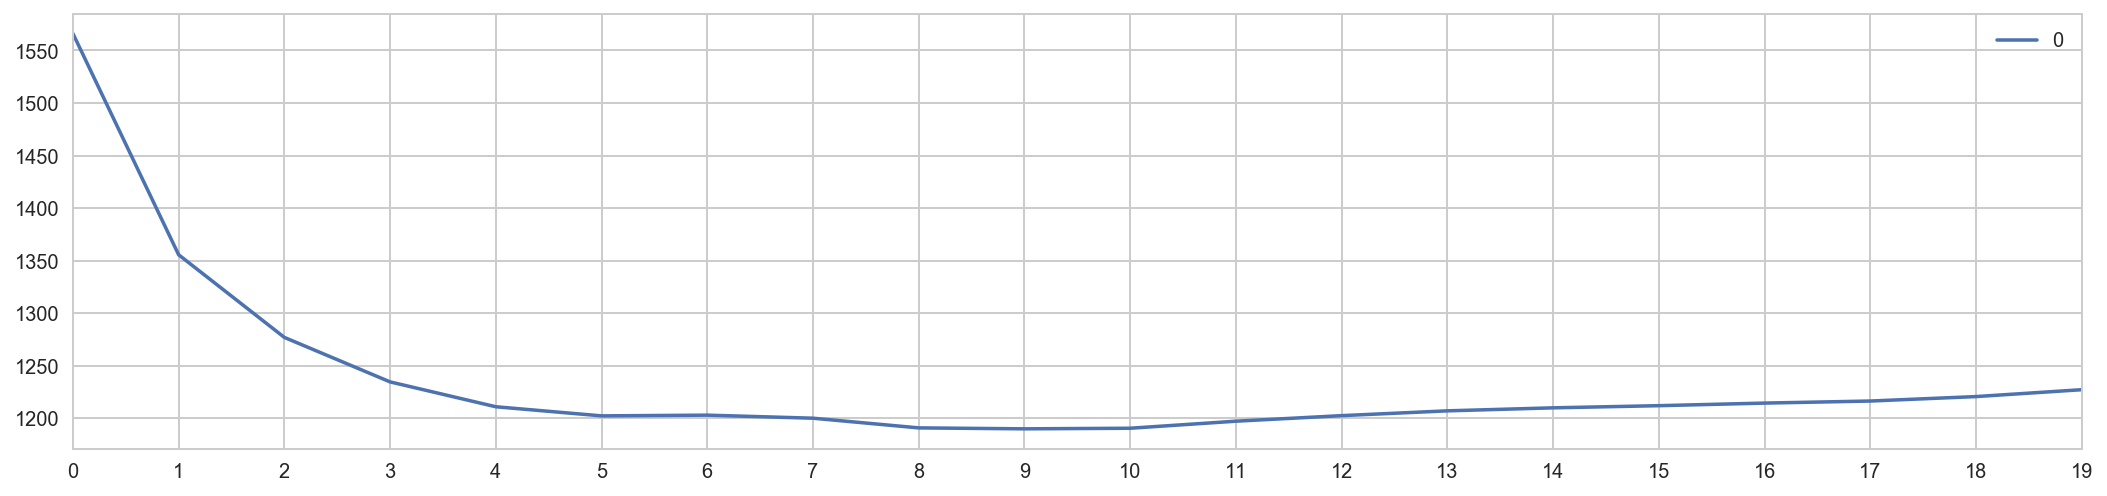

In [20]:
#plotting the rmse values against k values
pd.DataFrame(rmse_val).plot()
plt.xticks(range(20)); #elbow curve 

As we discussed, when we take k=1, we get a very high RMSE value. The RMSE value decreases as we increase the k value. At k= 7, the RMSE is approximately 1219.06, and shoots up on further increasing the k value. We can safely say that k=7 will give us the best result in this case.

These are the predictions using our training dataset. Let us now predict the values for test dataset and make a submission.

### 7. Predictions on the test dataset

In [21]:
#reading test and submission files
test_df = pd.read_csv('data/AV_Big_Mart_Sales_3/test.csv')

In [22]:
submission_df = pd.read_csv('data/AV_Big_Mart_Sales_3/sample_submission.csv')
submission_df['Item_Identifier'] = test_df['Item_Identifier']
submission_df['Outlet_Identifier'] = test_df['Outlet_Identifier']

In [23]:
#preprocessing test dataset
test_df.drop(['Item_Identifier', 'Outlet_Identifier'], axis=1, inplace=True)
test_df['Item_Weight'].fillna(mean, inplace =True)
test_df = pd.get_dummies(test_df)
test_scaled = scaler.fit_transform(test_df)
test_df = pd.DataFrame(test_scaled)

In [24]:
#predicting on the test set and creating submission file
predict = model.predict(test_df)
submission_df['Item_Outlet_Sales'] = predict
submission_df.to_csv('data/AV_Big_Mart_Sales_3/submit_file.csv',index=False)